
# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [3]:
pip install "gymnasium[mujoco]" mujoco torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 20.6 MB/s eta 0:00:00


In [1]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [26]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [22]:

class Replay:
    def __init__(self, obs_dim, act_dim, size=100000):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.next_obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr = 0
        self.size = size
        self.full = False

    def store(self, obs, act, rew, next_obs, done):
        i = self.ptr
        self.obs_buf[i] = obs
        self.act_buf[i] = act
        self.rew_buf[i] = rew
        self.next_obs_buf[i] = next_obs
        self.done_buf[i] = done

        self.ptr = (self.ptr + 1) % self.size
        if self.ptr == 0:
            self.full = True

    def sample(self, batch):
        max_size = self.size if self.full else self.ptr
        idx = np.random.randint(0, max_size, size=batch)
        return (self.obs_buf[idx],
                self.act_buf[idx],
                self.rew_buf[idx],
                self.next_obs_buf[idx],
                self.done_buf[idx])

replay = Replay(obs_dim, act_dim)
print("Replay buffer created.")


Replay buffer created.



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [23]:
def collect_random(env, replay, steps=10000, seed=42):
    np.random.seed(seed)
    obs, _ = env.reset(seed=seed)
    for _ in range(steps):
        act = env.action_space.sample()
        next_obs, rew, done, trunc, _ = env.step(act)
        replay.store(obs, act, rew, next_obs, done)

        if done or trunc:
            obs, _ = env.reset()
        else:
            obs = next_obs



## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [24]:

obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    max_size = replay.size if replay.full else replay.ptr

    for i in range(max_size):
        s = replay.obs_buf[i]
        a = replay.act_buf[i]
        s_next = replay.next_obs_buf[i]

        inp = np.concatenate([s, a], axis=-1)
        delta_s = s_next - s

        obs_norm.update(s)
        inp_norm.update(inp)
        targ_norm.update(delta_s)


update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [25]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



In [27]:
replay = Replay(obs_dim, act_dim)

collect_random(env, replay, steps=10_000)  # 至少几千步
print("ptr =", replay.ptr)  # 确认 > 0


ptr = 10000


In [28]:
obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
tgt_norm = RunningNormalizer(obs_dim)
update_normalizers_from_buffer(replay)


In [33]:

def train_model(model, replay, epochs=100, batch=256, steps_per_epoch=500,
                lr=3e-4, clip_grad=1.0, clip_norm=5.0):
    model.train().to(th.float32)
    opt = th.optim.Adam(model.parameters(), lr=lr)
    mse = th.nn.MSELoss()

    cur_size = replay.size if getattr(replay, "full", False) else replay.ptr
    if cur_size < batch:
        raise ValueError(f"Replay has only {cur_size} samples; collect_random(...) more first.")

    epoch_losses = []

    for ep in range(epochs):
        batch_losses = []

        for _ in range(steps_per_epoch):
            s, a, _, s_next, _ = replay.sample(batch)

            # numpy -> torch.float32
            s      = th.as_tensor(s,      dtype=th.float32)
            a      = th.as_tensor(a,      dtype=th.float32)
            s_next = th.as_tensor(s_next, dtype=th.float32)

            delta_s = s_next - s
            inp     = th.cat([s, a], dim=-1)

            # normalization
            inp_n = th.as_tensor(inp_norm.normalize(inp.cpu().numpy()), dtype=th.float32)
            tgt_n = th.as_tensor(tgt_norm.normalize(delta_s.cpu().numpy()), dtype=th.float32)

            inp_n = th.clamp(inp_n, -5.0, 5.0)
            tgt_n = th.clamp(tgt_n, -5.0, 5.0)

            pred = model(inp_n)
            loss = mse(pred, tgt_n)

            opt.zero_grad(set_to_none=True)
            loss.backward()

            if clip_grad is not None:
                for p in model.parameters():
                    if p.grad is not None:
                        p.grad.data.clamp_(-clip_grad, clip_grad)
            if clip_norm is not None:
                th.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            opt.step()
            batch_losses.append(loss.item())

        ep_mean = float(np.mean(batch_losses))
        epoch_losses.append(ep_mean)
        print(f"Epoch {ep:03d} | loss={ep_mean:.4f}")

    return epoch_losses


Epoch 000 | loss=1.4730
Epoch 001 | loss=0.6847
Epoch 002 | loss=0.3689
Epoch 003 | loss=0.2603
Epoch 004 | loss=0.2174
Epoch 005 | loss=0.1936
Epoch 006 | loss=0.1774
Epoch 007 | loss=0.1639
Epoch 008 | loss=0.1545
Epoch 009 | loss=0.1454
Epoch 010 | loss=0.1386
Epoch 011 | loss=0.1342
Epoch 012 | loss=0.1266
Epoch 013 | loss=0.1225
Epoch 014 | loss=0.1178
Epoch 015 | loss=0.1134
Epoch 016 | loss=0.1097
Epoch 017 | loss=0.1057
Epoch 018 | loss=0.1022
Epoch 019 | loss=0.0992
Epoch 020 | loss=0.0967
Epoch 021 | loss=0.0944
Epoch 022 | loss=0.0913
Epoch 023 | loss=0.0891
Epoch 024 | loss=0.0863
Epoch 025 | loss=0.0841
Epoch 026 | loss=0.0829
Epoch 027 | loss=0.0804
Epoch 028 | loss=0.0784
Epoch 029 | loss=0.0769
Epoch 030 | loss=0.0754
Epoch 031 | loss=0.0737
Epoch 032 | loss=0.0717
Epoch 033 | loss=0.0704
Epoch 034 | loss=0.0691
Epoch 035 | loss=0.0678
Epoch 036 | loss=0.0665
Epoch 037 | loss=0.0651
Epoch 038 | loss=0.0636
Epoch 039 | loss=0.0625
Epoch 040 | loss=0.0614
Epoch 041 | loss

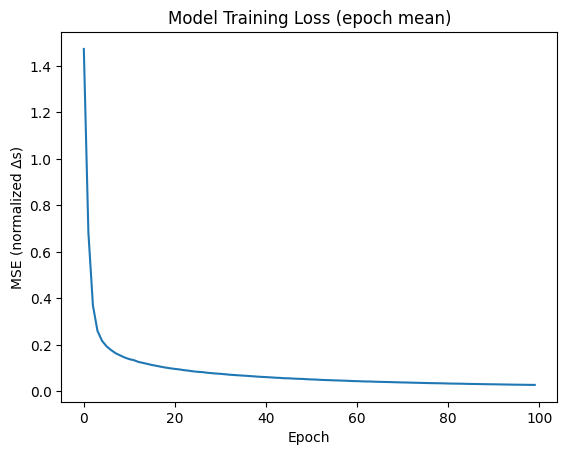

In [34]:
losses = train_model(model, replay, epochs=100, batch=256, steps_per_epoch=500, lr=3e-4)
plt.figure()
plt.plot(losses)
plt.title("Model Training Loss (epoch mean)")
plt.xlabel("Epoch"); plt.ylabel("MSE (normalized Δs)")
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

In [35]:
def collect_eval_set(env, n=5000, seed=123):
    rng = np.random.RandomState(seed)
    obs, _ = env.reset(seed=seed)
    S, A, S_next = [], [], []

    for _ in range(n):
        act = env.action_space.sample()
        nxt, rew, term, trunc, _ = env.step(act)
        S.append(obs.astype(np.float32))
        A.append(act.astype(np.float32))
        S_next.append(nxt.astype(np.float32))
        if term or trunc:
            obs, _ = env.reset()
        else:
            obs = nxt
    return np.asarray(S), np.asarray(A), np.asarray(S_next)


In [36]:

def one_step_mse(model, S, A, S_next):
    model.eval().to(th.float32)
    with th.no_grad():
        S_t = th.as_tensor(S, dtype=th.float32)
        A_t = th.as_tensor(A, dtype=th.float32)
        Snext_t = th.as_tensor(S_next, dtype=th.float32)

        dS_true = Snext_t - S_t
        inp = th.cat([S_t, A_t], dim=-1)

        inp_n = th.as_tensor(inp_norm.normalize(inp.cpu().numpy()), dtype=th.float32)
        dS_pred_n = model(inp_n)
        dS_pred = th.as_tensor(tgt_norm.denormalize(dS_pred_n.cpu().numpy()), dtype=th.float32)

        mse_dS  = th.mean((dS_pred - dS_true) ** 2).item()
        S_pred  = S_t + dS_pred
        mse_S   = th.mean((S_pred - Snext_t) ** 2).item()

    return {"mse_delta_s": mse_dS, "mse_next_state": mse_S}


In [37]:
S_val, A_val, Snext_val = collect_eval_set(env, n=5000, seed=2025)
one_step_metrics = one_step_mse(model, S_val, A_val, Snext_val)
print(one_step_metrics)

{'mse_delta_s': 13.76281452178955, 'mse_next_state': 13.76281452178955}


In [38]:
def multi_step_curve(env, model, k=20, episodes=100, seed=2025):
    model.eval().to(th.float32)
    rng = np.random.RandomState(seed)
    per_step_mse = np.zeros(k, dtype=np.float64)

    for _ in range(episodes):
        obs_real, _ = env.reset(seed=rng.randint(0, 10**6))
        obs_model = obs_real.copy()

        acts = [env.action_space.sample() for _ in range(k)]

        for t, act in enumerate(acts):
            nxt, _, term, trunc, _ = env.step(act)
            obs_real = nxt

            inp = np.concatenate([obs_model, act]).astype(np.float32)
            inp_t = th.as_tensor(inp, dtype=th.float32)
            inp_n = th.as_tensor(inp_norm.normalize(inp_t.cpu().numpy()), dtype=th.float32)
            with th.no_grad():
                d_pred_n = model(inp_n).cpu().numpy()
            d_pred = tgt_norm.denormalize(d_pred_n).astype(np.float32)
            obs_model = obs_model + d_pred

            per_step_mse[t] += np.mean((obs_model - obs_real) ** 2)

            if term or trunc:
                break

    per_step_mse /= episodes
    return per_step_mse  # shape [k]


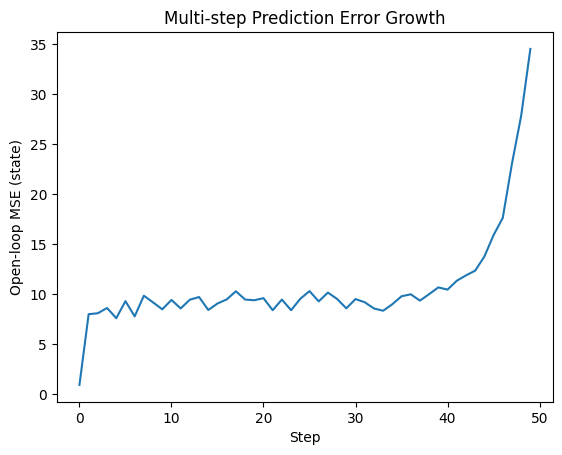

In [39]:
mses = multi_step_curve(env, model, k=50, episodes=200)
plt.figure()
plt.plot(mses)
plt.xlabel("Step")
plt.ylabel("Open-loop MSE (state)")
plt.title("Multi-step Prediction Error Growth")
plt.show()



## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



In [40]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt

def visualize_rollout(env, model, k=50, seed=0, dims=(0,1,2)):
    """
    Visualize real vs model rollout under the same pre-sampled action sequence.

    Args:
        env: gym/gymnasium env
        model: dynamics net, takes normalized [s,a] and outputs normalized Δs
        k: rollout horizon
        seed: env reset seed
        dims: tuple of state indices to plot
    Returns:
        real_traj (T×|dims|), model_traj (T×|dims|), actions (T×act_dim)
    """
    model.eval().to(th.float32)

    # 1) reset & keep initial obs
    obs_real, _ = env.reset(seed=seed)
    obs_model = obs_real.astype(np.float32).copy()

    # 2) pre-sample actions so both paths see the same sequence
    actions = [env.action_space.sample() for _ in range(k)]

    # store trajectories (include initial point for reference if你想，也可不含)
    real_traj, model_traj = [], []

    # 3) open-loop forward for k steps
    for a in actions:
        # ---- real env step
        next_obs, _, terminated, truncated, _ = env.step(a)
        obs_real = next_obs

        # ---- model step: build [s_model, a] → normalize → tensor(float32) → net → denorm → add
        inp = np.concatenate([obs_model, a]).astype(np.float32)        # [obs_dim + act_dim]
        inp_n = inp_norm.normalize(inp)                                # numpy
        inp_t = th.as_tensor(inp_n, dtype=th.float32).unsqueeze(0)     # [1, D]

        with th.no_grad():
            d_pred_n = model(inp_t).cpu().numpy().squeeze(0)           # normalized Δs
        d_pred = tgt_norm.denormalize(d_pred_n).astype(np.float32)     # de-normalized Δs
        obs_model = obs_model + d_pred

        # ---- record selected dims
        real_traj.append(obs_real[list(dims)])
        model_traj.append(obs_model[list(dims)])

        # ---- stop early on termination/truncation
        if terminated or truncated:
            break

    real_traj = np.asarray(real_traj)    # [T, |dims|]
    model_traj = np.asarray(model_traj)  # [T, |dims|]
    actions = np.asarray(actions)[:len(real_traj)]

    # 4) plot
    T = real_traj.shape[0]
    plt.figure(figsize=(12, 3.5))
    for i, d in enumerate(dims):
        plt.subplot(1, len(dims), i+1)
        plt.plot(range(T), real_traj[:, i], label="real")
        plt.plot(range(T), model_traj[:, i], label="model")
        plt.title(f"state dim {d}")
        plt.xlabel("step");
        if i == 0:
            plt.ylabel("value")
        plt.grid(alpha=0.3)
    plt.suptitle("Open-loop Rollout: Real vs Model")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    return real_traj, model_traj, actions


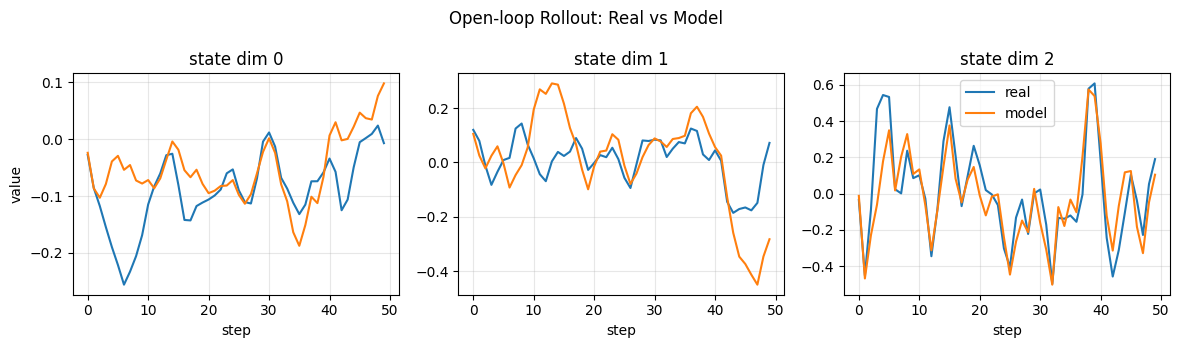

In [41]:

real_traj, model_traj, acts = visualize_rollout(env, model, k=50, seed=2025, dims=(0,1,2))



## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.



# 1. How good is your model?

The one-step loss is very low and the training curve shows fast and stable convergence, suggesting that the model learns local dynamics well. In the short horizon (first 10–20 steps), the open-loop rollouts also match the real trajectories reasonably. However, the multi-step error grows quickly after longer horizons, meaning the model is only accurate locally but drifts over time when errors accumulate.

# 2. Is this training enough for planning, or do we need continual training?

This training is not enough for long-horizon planning. Even though one-step prediction is accurate, errors compound in open-loop rollouts, causing the system to diverge after ~20–30 steps. A practical planner would require continual training or iterative data collection to keep the model accurate in regions visited by the current policy.

# 3. How is this system different from the Mountain Car problem? Why can't we learn this in one episode?

HalfCheetah has a much higher-dimensional, continuous, and highly non-linear dynamical system compared to Mountain Car. The state and action spaces are larger, and the dynamics vary significantly across different velocities, joint angles, and contact conditions. A single episode covers only a tiny portion of the full state distribution, so many episodes of diverse transitions are needed to learn a generalizable model.

# 4. Why do we use a running normalizer instead of a static normalizer?

A running normalizer adapts to the data distribution as more transitions are collected. In model-based RL, the distribution of visited states can shift as policies improve or as more data is gathered. A static normalizer computed from a small initial batch may become inaccurate, while a running normalizer maintains stable scaling and prevents exploding/vanishing gradients during training.